# **Import the libraries and csv files**

In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the csv files
articles = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/h-and-m-personalized-fashion-recommendations/articles.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
customers = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/h-and-m-personalized-fashion-recommendations/customers.csv")
colors = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/h-and-m-personalized-fashion-recommendations/colors.csv")

# **Check the data**

In [ ]:
articles.info()
articles.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

,0
article_id,int64
product_code,int64
prod_name,object
product_type_no,int64
product_type_name,object
product_group_name,object
graphical_appearance_no,int64
graphical_appearance_name,object
colour_group_code,int64
colour_group_name,object


In [ ]:
transactions.info()
transactions.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


,0
t_dat,object
customer_id,object
article_id,int64
price,float64
sales_channel_id,int64


In [ ]:
customers.info()
customers.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


,0
customer_id,object
FN,float64
Active,float64
club_member_status,object
fashion_news_frequency,object
age,float64
postal_code,object


In [ ]:
colors.info()
colors.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   color_name  38 non-null     object
 1   color_type  38 non-null     object
dtypes: object(2)
memory usage: 736.0+ bytes


,0
color_name,object
color_type,object


# **Preprocessing**

In [ ]:
# Filter datasets for performance
item_freq = transactions['article_id'].value_counts()
user_freq = transactions['customer_id'].value_counts()

filtered_items = item_freq[item_freq >= 100].index
filtered_users = user_freq[user_freq >= 100].index

filtered_df = transactions[transactions['article_id'].isin(filtered_items) & transactions['customer_id'].isin(filtered_users)]

In [ ]:
freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')

GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')

GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

In [ ]:
# Check the dataset after controling weight and search bias
display(GraphTravel_HM)

print("unique customer_id" , GraphTravel_HM.customer_id.nunique())
print("unique article_id" , GraphTravel_HM.article_id.nunique())

,t_dat,customer_id,article_id,price,sales_channel_id,frequency
243,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
244,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
245,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
705,2018-09-20,11f43e432512cea4860b2f3bdb9870269a594ce231b84b...,400285006,0.044051,2,12
706,2018-09-20,11f43e432512cea4860b2f3bdb9870269a594ce231b84b...,400285006,0.044051,2,12
...,...,...,...,...,...,...
8873999,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11
8874000,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012915,2,11
8874001,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11
8879038,2020-09-22,cb81d5c319424e49ce6d69df02f7003341a22a5e94c2b7...,685816002,0.008458,1,13


unique customer_id 1882
unique article_id 1823


<ipython-input-9-68e022e98ebb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)


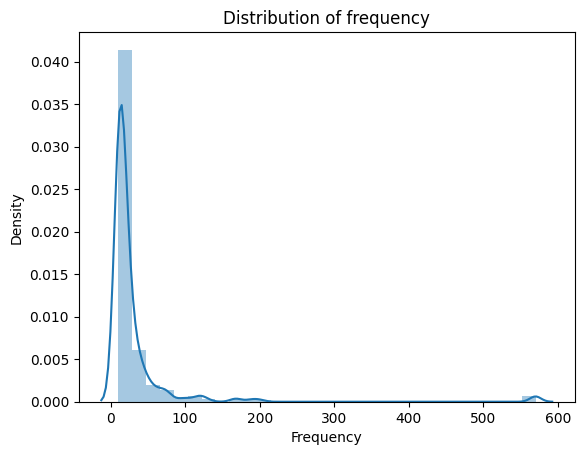

In [ ]:
# Distribution of frequency
sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)

plt.title('Distribution of frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')

plt.show()

In [ ]:
# Add 'personal_color' column to customers dataset
personal_colors = ['spring', 'summer', 'autumn', 'winter']
customers['personal_color'] = np.random.choice(personal_colors, size=len(customers))
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,personal_color
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,winter
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,winter
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,spring
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,spring
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,winter


In [ ]:
# Merge articles and colors data on 'colour_group_name' and 'color_name' from the colors file
color_mapping = colors[['color_name', 'color_type']].rename(columns={'color_name': 'colour_group_name'})
recommendation_data = pd.merge(articles, color_mapping, how='left', on='colour_group_name')

# Merge with customers data to associate customer personal color with articles
recommendation_data = pd.merge(recommendation_data, customers[['customer_id', 'personal_color']],
                               how='left', left_on='color_type', right_on='personal_color')

print(recommendation_data.head())

   article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid               

In [ ]:
# Customer ID mapping
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

# Make a item recommendation model

In [ ]:
G = nx.Graph()

for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

In [ ]:
# Biased random walk
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter
                        probability.append(1)
                    else:
                        # In-out parameter
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk

In [ ]:
# Generate random walks
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [ ]:
# Train Word2Vec model
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
filtered_walks = [walk for walk in walks if len(walk) >= 5]

# to String  (for Word2Vec input)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec train
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)

# node embedding extract
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}

In [ ]:
# Get user embedding
def get_user_embedding(user_id, embeddings):
    return embeddings[str(user_id)]

In [ ]:
# Get rated items
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])

In [ ]:
# Calculate item similarities with personal color filter
def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities

In [ ]:
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"/content/drive/MyDrive/Colab Notebooks/data/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()

In [ ]:
def recommend_items(user_id, df, embeddings, item_name_mapping, recommendation_data, customers, num_items=5):
    # Create a user_id to customer_id mapping
    user_id_to_customer_id = {v: k for k, v in customer_id_mapping.items()}

    # Map the user_id to the corresponding customer_id
    if user_id not in user_id_to_customer_id:
        print(f"User ID {user_id} not found in transactions data.")
        return

    customer_id = user_id_to_customer_id[user_id]
    print(f"Mapped User ID {user_id} to Customer ID: {customer_id}")

    # Retrieve items rated/purchased by the user
    rated_items = get_rated_items(user_id, df)

    print(f"User {user_id} (Customer ID: {customer_id}) has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))

    # Retrieve the personal color of the customer
    if customer_id in customers['customer_id'].values:
        customer_color = customers[customers['customer_id'] == customer_id]['personal_color'].values[0]
        print(f"Customer {customer_id} has personal color: {customer_color}")

        # Normalize color types
        recommendation_data['color_type'] = recommendation_data['color_type'].str.lower()

        # Filter recommendation data by personal color
        filtered_recommendation_data = recommendation_data[recommendation_data['color_type'] == customer_color]
        print(f"Filtering by personal color '{customer_color}' returned {len(filtered_recommendation_data)} items.")

        if not filtered_recommendation_data.empty:
            # Filter recommendations based on customer color
            item_similarities = calculate_similarities(user_id, df, embeddings)
            recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

            # Apply the personal color filter to recommended items
            recommended_items_filtered = [
                (item_id, similarity) for item_id, similarity in recommended_items
                if item_id in filtered_recommendation_data['article_id'].values
            ]

            if recommended_items_filtered:
                print(f"\nRecommended items for user {user_id} (filtered by personal color {customer_color}):")
                show_images(recommended_items_filtered, item_name_mapping, num_items, show_similarity=True)
            else:
                print(f"No recommendations found for personal color: {customer_color}. Showing unfiltered recommendations.")
                item_similarities = calculate_similarities(user_id, df, embeddings)
                recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]
                show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)
        else:
            print(f"No items with color type '{customer_color}' found. Showing unfiltered recommendations.")
            item_similarities = calculate_similarities(user_id, df, embeddings)
            recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]
            show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)
    else:
        print(f"Customer ID {customer_id} not found in customers data. Skipping personal color filter.")
        item_similarities = calculate_similarities(user_id, df, embeddings)
        recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]
        show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)

Mapped User ID 18 to Customer ID: 25e260e20705dc6401c8216ba20f63d51467092e79a71d80c7ae9aeab19a8a0e
User 18 (Customer ID: 25e260e20705dc6401c8216ba20f63d51467092e79a71d80c7ae9aeab19a8a0e) has purchased:
- Item 556260002: Skinny L.W Elite
- Item 399087015: S.Skinny L.W Epic
- Item 719209003: Kahl denim skirt
- Item 730013004: Shorts Slim Midas Zip Fly
- Item 622969007: Sweetheart boot


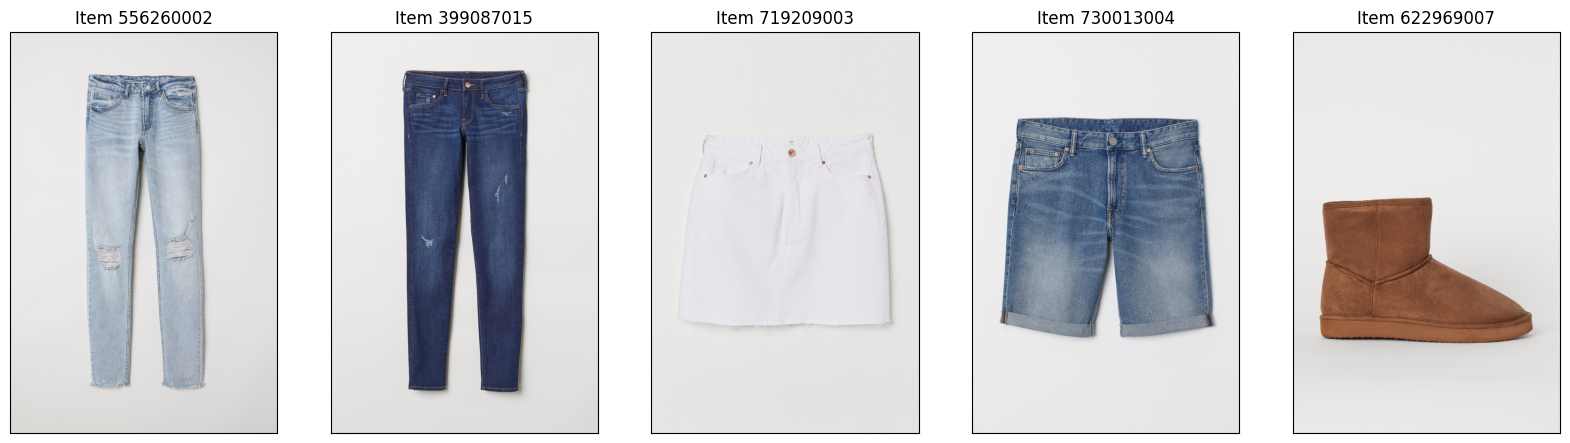

Customer 25e260e20705dc6401c8216ba20f63d51467092e79a71d80c7ae9aeab19a8a0e has personal color: winter
Filtering by personal color 'winter' returned 52536 items.

Recommended items for user 18 (filtered by personal color winter):
- Item 487827024: Skinny H.W with similarity score: 0.7942394018173218
- Item 698776002: James Biker with similarity score: 0.6454203128814697
- Item 400285006: Straight R.W with similarity score: 0.5851445198059082


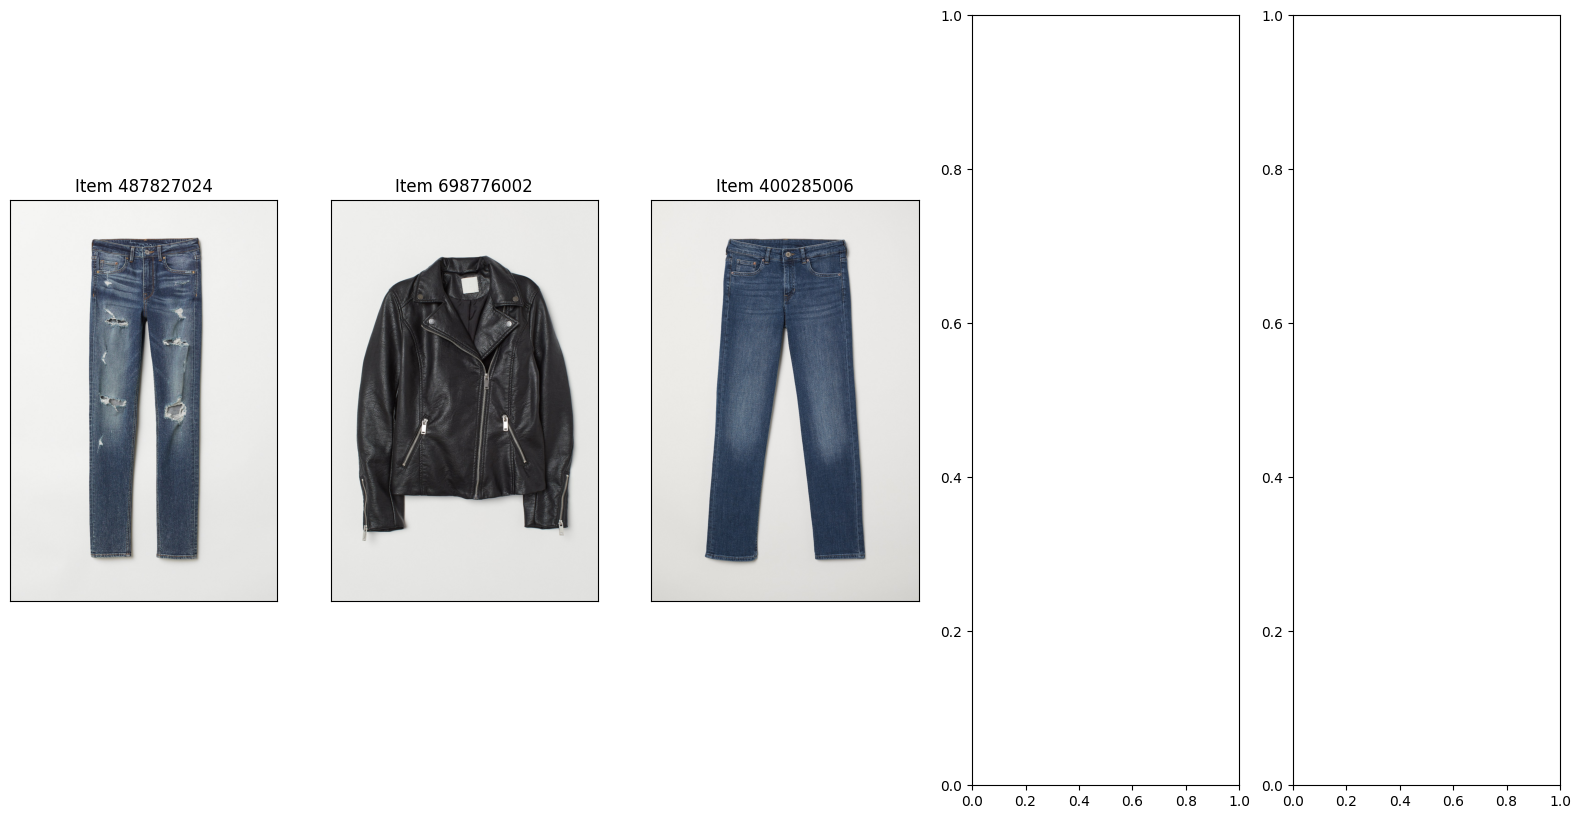

In [ ]:
recommend_items(
    user_id=18,
    df=GraphTravel_HM,
    embeddings=embeddings,
    item_name_mapping=item_name_mapping,
    recommendation_data=recommendation_data,
    customers=customers,
    num_items=5
)

Mapped User ID 1018 to Customer ID: 494d5691c55c0d52487f638a35d10bd983af5e367ca75ad27a7857cadbf252d5
User 1018 (Customer ID: 494d5691c55c0d52487f638a35d10bd983af5e367ca75ad27a7857cadbf252d5) has purchased:
- Item 486639003: Jackie brief 2pk HR LS


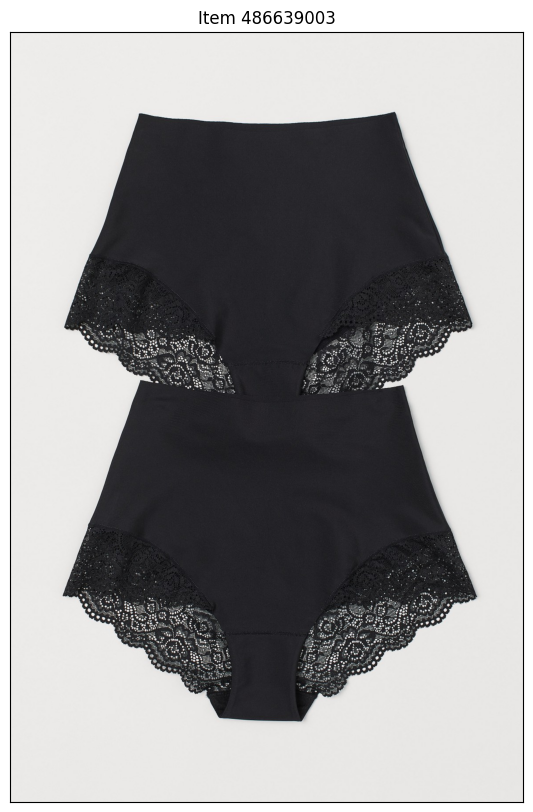

Customer 494d5691c55c0d52487f638a35d10bd983af5e367ca75ad27a7857cadbf252d5 has personal color: winter
Filtering by personal color 'winter' returned 52536 items.

Recommended items for user 1018 (filtered by personal color winter):
- Item 469658009: Spice Girl 3pk hipster with similarity score: 0.9898137450218201
- Item 747807002: Alpha top with similarity score: 0.598365306854248
- Item 589599002: Shake it in Balconette_ with similarity score: 0.5962070226669312
- Item 634775006: Canna LS with similarity score: 0.595907986164093


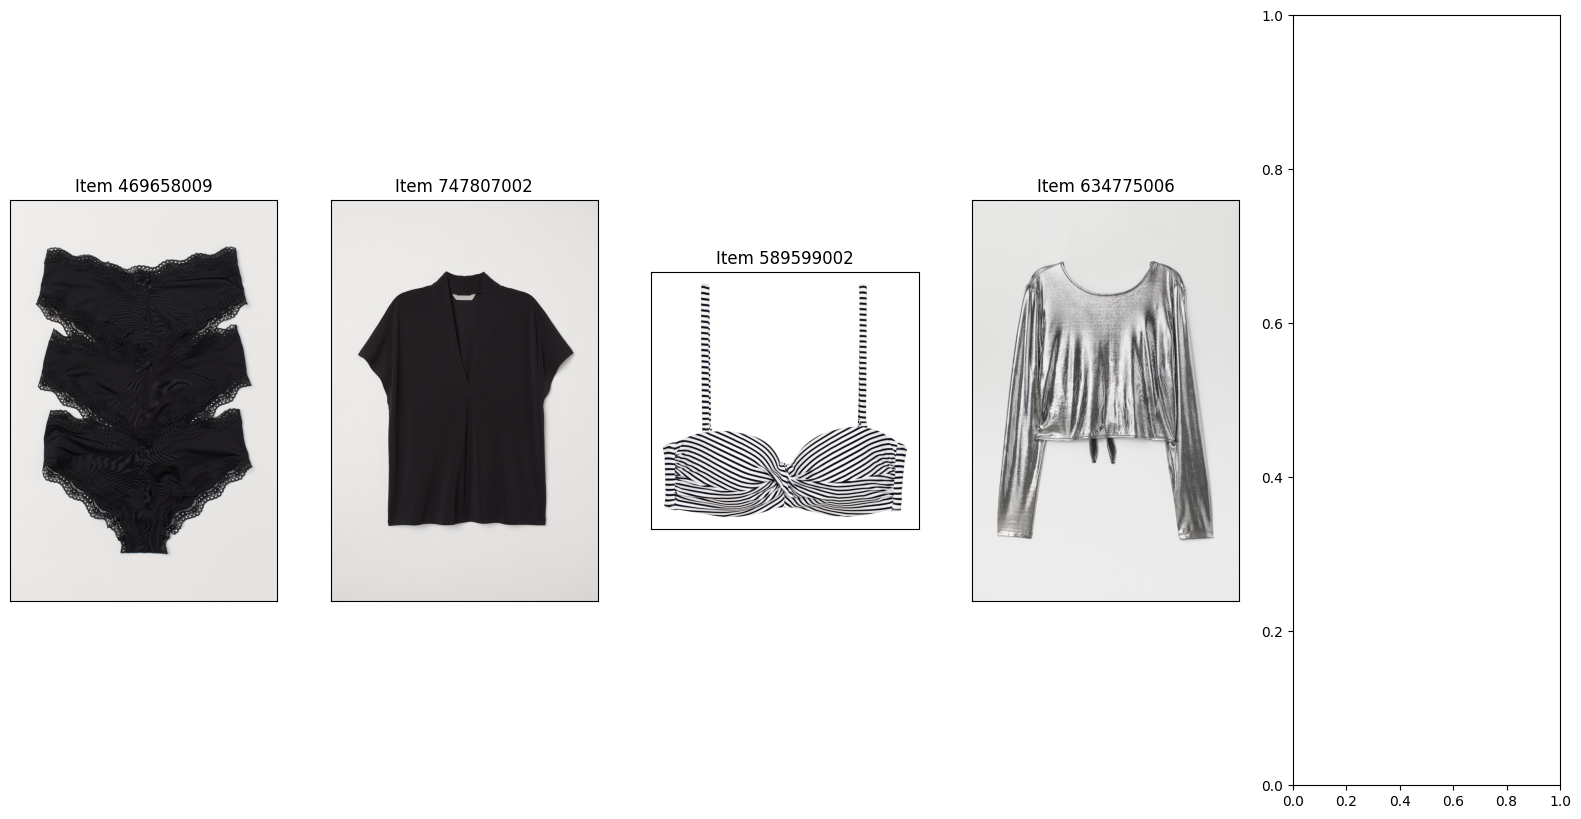

In [ ]:
recommend_items(
    user_id=1018,
    df=GraphTravel_HM,
    embeddings=embeddings,
    item_name_mapping=item_name_mapping,
    recommendation_data=recommendation_data,
    customers=customers,
    num_items=5
)

Mapped User ID 14 to Customer ID: e7c3ac9a8c86813e4a543b6215576c200c2cb56c670eac2b67a88ee3d78628a1
User 14 (Customer ID: e7c3ac9a8c86813e4a543b6215576c200c2cb56c670eac2b67a88ee3d78628a1) has purchased:
- Item 501616009: FRAME Easy Iron
- Item 722475005: FRAME Easy Iron TVP
- Item 667499001: Despacito (1)


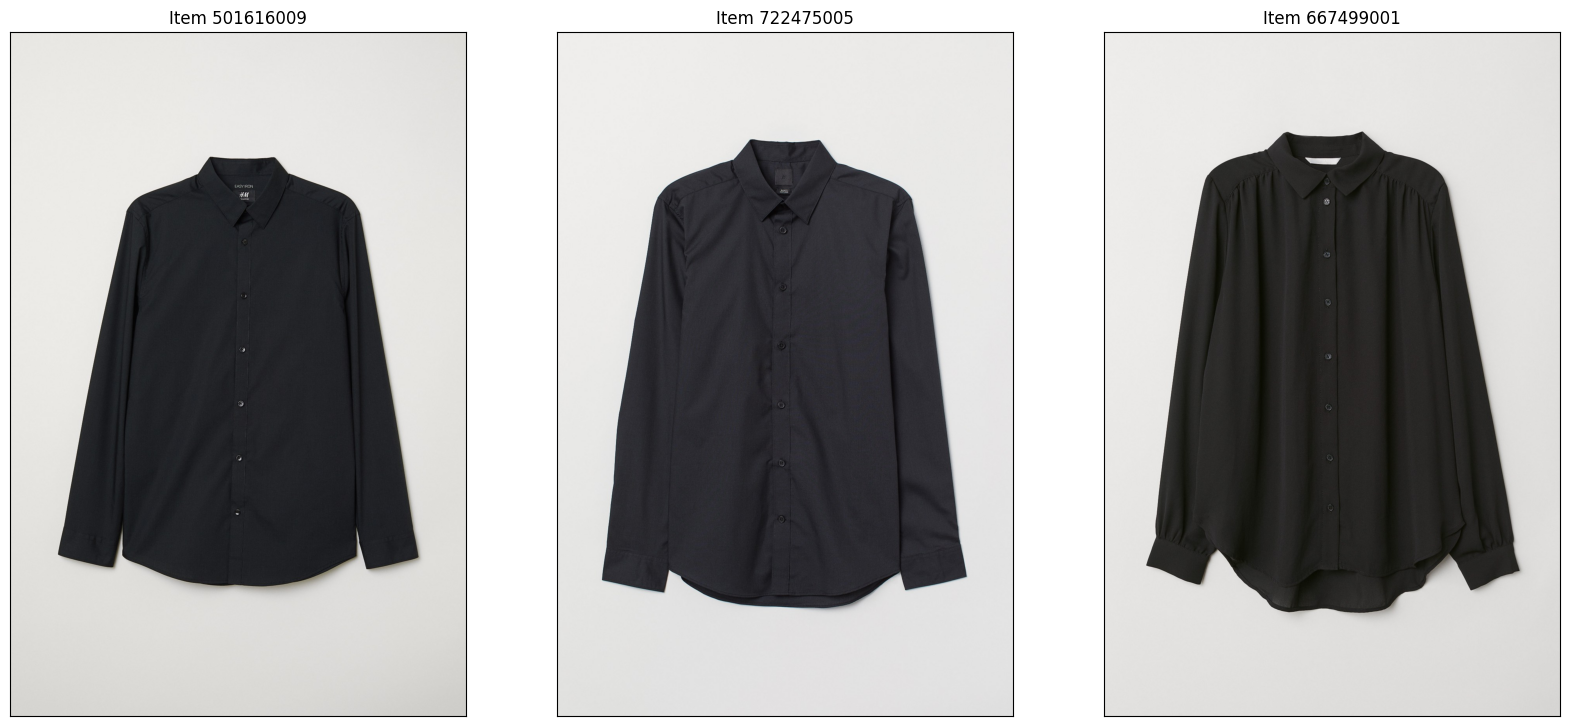

Customer e7c3ac9a8c86813e4a543b6215576c200c2cb56c670eac2b67a88ee3d78628a1 has personal color: summer
Filtering by personal color 'summer' returned 15973 items.
No recommendations found for personal color: summer. Showing unfiltered recommendations.
- Item 781758003: FRAME Easy Care TVP with similarity score: 0.8228641748428345
- Item 512385008: Drape LS shirt with similarity score: 0.8166605234146118
- Item 762856007: Tina Blouse with similarity score: 0.8151109218597412
- Item 507910004: Isabella with similarity score: 0.7958881855010986
- Item 685848007: Pomme tunic with similarity score: 0.7221184968948364


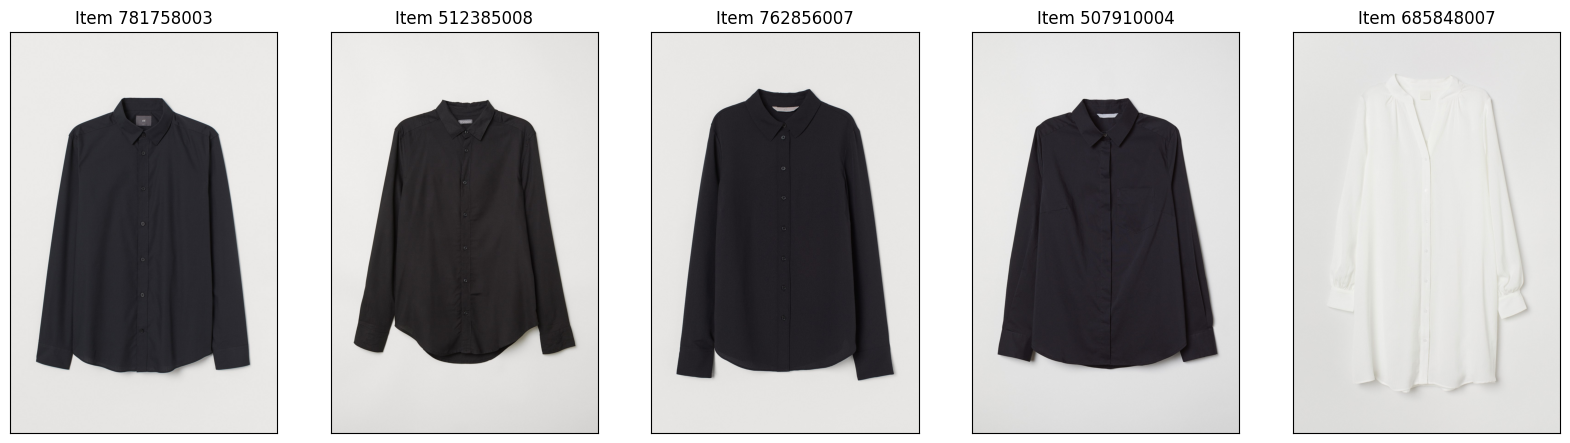

In [ ]:
recommend_items(
    user_id=14,
    df=GraphTravel_HM,
    embeddings=embeddings,
    item_name_mapping=item_name_mapping,
    recommendation_data=recommendation_data,
    customers=customers,
    num_items=5
)

# Reference

https://www.kaggle.com/code/khyj00/gnns-similarity-recommendation-based-on-node2vec